<a href="https://colab.research.google.com/github/sthalles/computer-vision/blob/master/project-3/CountLines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import cv2
import imageio
import matplotlib.pyplot as plt
import numpy as np

In [0]:
# read the input image 
img = imageio.imread('http://www.ic.unicamp.br/~helio/imagens_morfologia/bitmap.pbm')

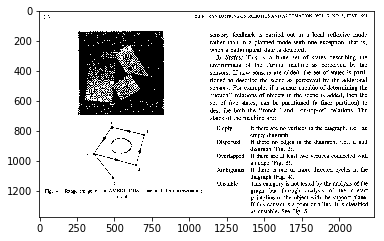

In [0]:
# Display original image
plt.imshow(img, cmap="gray")
plt.show()

In [0]:
# transform the image to binary with 0s and 1s
img = img // 255

In [0]:
img = cv2.bitwise_not(img)


[0 1]


In [0]:
# transform the image to binary with 0s and 1s
img = img // 255

# invert the pixel values
# 0: background
# 1: foreground
img = cv2.bitwise_not(img)-254

n_pixels = img.shape[0] * img.shape[1]
print("Number of pixels:", n_pixels)
print("Image shape:",img.shape)
print("Unique values:",np.unique(img))

Number of pixels: 3068142
Image shape: (1374, 2233)
Unique values: [0 1]


In [0]:
n_white_pixels = np.count_nonzero(img)
n_black_pixels = n_pixels - n_white_pixels
print("# foreground pixels:", n_white_pixels, "# background pixels:", n_black_pixels, "Image shape:",img.shape)

# foreground pixels: 470254 # background pixels: 2597888 Image shape: (1374, 2233)


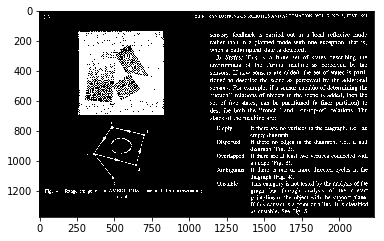

In [0]:
# Show binary image
plt.imshow(img, cmap="gray")
plt.show()

In [0]:
# create separate copies of the images
horizontal = np.copy(img)
vertical = np.copy(img)
print(np.unique(vertical))

[0 1]


In [0]:
# create horizontal structuring element
horizontal_size = 100
# Structure element for extracting horizontal lines (100 pixels wide 1 pixel tall)
horizontalStructure = cv2.getStructuringElement(cv2.MORPH_RECT, (horizontal_size, 1))


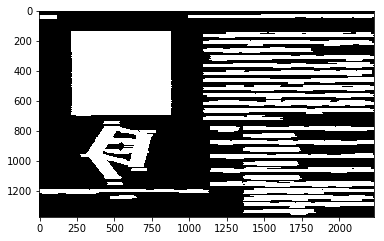

In [0]:
# Apply morphology operations - Dilate
horizontal = cv2.dilate(horizontal, horizontalStructure)
plt.imshow(horizontal, cmap="gray")
plt.show()

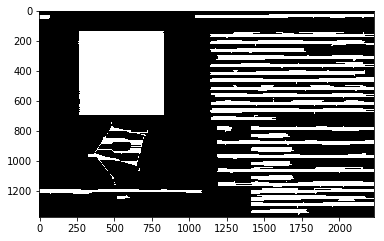

In [0]:
# Erode the image
horizontal = cv2.erode(horizontal, horizontalStructure)

plt.imshow(horizontal, cmap="gray")
plt.show()

[0 1]


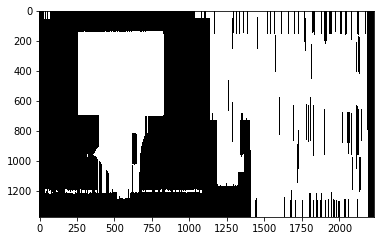

In [0]:
verticalsize = 200
# Structure element for extracting vertical lines (200 pixels tall and 1 pixel wide)
verticalStructure = cv2.getStructuringElement(cv2.MORPH_RECT, (1, verticalsize))

# Vertical dilation
vertical = cv2.dilate(vertical, verticalStructure)

# Vertical Erosion
vertical = cv2.erode(vertical, verticalStructure)

# Inverse vertical image
# vertical = cv2.bitwise_not(vertical)-254
plt.imshow(vertical, cmap="gray")
print(np.unique(vertical))

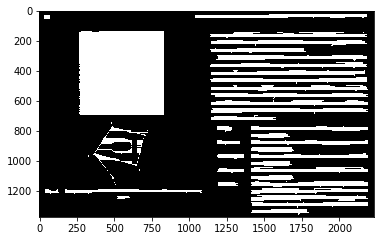

In [0]:
# Combine vertial and horizontal representations using an AND operation
merge = vertical * horizontal

# Close possible small holes using
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (30, 1))
closing = cv2.morphologyEx(merge, cv2.MORPH_CLOSE, kernel)
plt.imshow(closing, cmap="gray")
plt.imsave("closing.png", closing, cmap="gray")

In [0]:
nlabels, labels, stats, centroids = cv2.connectedComponentsWithStats(closing)
print("# of boxes:",nlabels)

# of boxes: 54


In [0]:
# Count pixel transitions
def count_transitions(img):
  assert len(np.unique(img)) <= 2, "Image is not binary"
  black_pixel = 0

  # template: white --> black
  template = [1,0]
  
  row_length = img.shape[1]
  if row_length % 2 != 0:
    row_length = row_length-1  
   
  transitions = 0
  for row in img:
    for i in range(row_length):
      if np.all(template == row[i:i+2]):
        transitions+=1
  return transitions

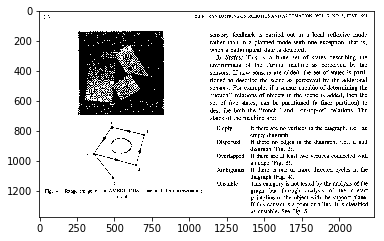

In [0]:
img = cv2.bitwise_not(img)-254
plt.imshow(img, cmap="gray")
plt.show()

In [0]:
# transform image to rgb to draw bboxes
rgb = np.zeros((img.shape[0], img.shape[1], 3))
rgb[:,:,0] = img
rgb[:,:,1] = img
rgb[:,:,2] = img

In [0]:
valid_transition_ratio = []
valid_pixel_ratio = []
#  para cada retângulo envolvendo um objeto, calcule:
for count, box in enumerate(stats):
    
    l = box[0]
    t = box[1]
    r = box[0] + box[2]
    b = box[1] + box[3]
    
    # get the bbox
    img_patch = closing[t:b,l:r]
    real_patch = img[t:b,l:r]

    n_pixels_box = img_patch.shape[0] * img_patch.shape[1]
    if (n_pixels_box / n_pixels) > 0.9:
      continue
    
    # razao entre o numero de pixels pretos e o numero total de pixels (altura × largura)
    # assumindo numero total de pixels do patch (box)
    # 0 --> black pixel
    # 1 --> white pixel
    
    n_white_pixels = np.count_nonzero(real_patch)
    n_black_pixels = n_pixels_box - n_white_pixels
    print("# white pixels:", n_white_pixels, "# black pixels:", n_black_pixels, "Image shape:",img_patch.shape)
    pixel_ratio = n_black_pixels / n_pixels_box
    
    ht = count_transitions(real_patch)
    vt = count_transitions(real_patch.T)
                    
    transition_ratio = (ht+vt)/n_pixels_box     

    if (pixel_ratio >= 0.19 and pixel_ratio <= 0.38) and (transition_ratio >= 0.063 and transition_ratio < 0.13):
      plt.imsave("patch_" + str(count) + ".png", real_patch, cmap="gray")
      cv2.rectangle(rgb,(l,t),(r,b),(0,255,0),2)

      valid_pixel_ratio.append(pixel_ratio)
      valid_transition_ratio.append(transition_ratio)
   

# white pixels: 20193 # black pixels: 8557 Image shape: (25, 1150)
# white pixels: 557 # black pixels: 325 Image shape: (21, 42)
# white pixels: 6 # black pixels: 0 Image shape: (3, 2)
# white pixels: 52281 # black pixels: 268611 Image shape: (561, 572)
# white pixels: 32858 # black pixels: 8982 Image shape: (40, 1046)
# white pixels: 32530 # black pixels: 9310 Image shape: (40, 1046)
# white pixels: 18473 # black pixels: 6331 Image shape: (39, 636)
# white pixels: 31218 # black pixels: 8055 Image shape: (39, 1007)
# white pixels: 33139 # black pixels: 8741 Image shape: (40, 1047)
# white pixels: 11 # black pixels: 9 Image shape: (5, 4)
# white pixels: 12 # black pixels: 8 Image shape: (5, 4)
# white pixels: 30834 # black pixels: 8876 Image shape: (38, 1045)
# white pixels: 32772 # black pixels: 9068 Image shape: (40, 1046)
# white pixels: 32045 # black pixels: 9795 Image shape: (40, 1046)
# white pixels: 32525 # black pixels: 9235 Image shape: (40, 1044)
# white pixels: 31960 # black 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


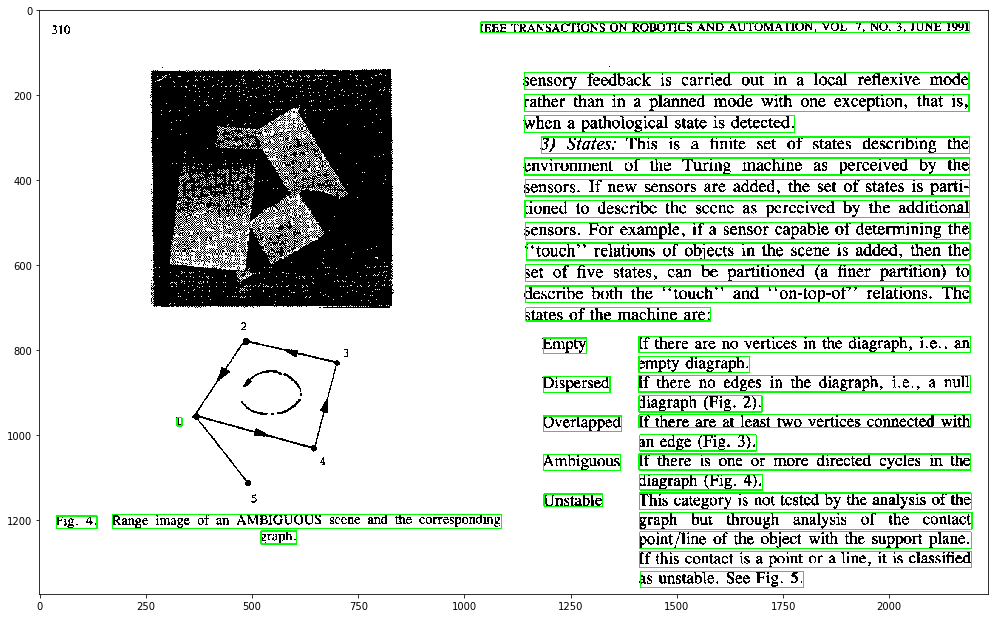

In [0]:
# This image has to be rbg to print colored boxes
plt.figure(figsize=(17,17))
plt.imshow(rgb)
plt.imsave("lines_final.png", rgb)

In [0]:
print("Total of lines:", len(valid_pixel_ratio))

Total of lines: 35
